# Part 1: Portfolio Optimization Based on Drift

The goal of this part is to do a portfolio optimization based on Merton that produces dynamically updated portfolio. The basic assumption is that the simple return has a (physical) drift rate mu, while the risk neutral drift is zero. The simple returns R(t) are assumed to have a normal distribution with volatility sigma. 

The discrepancy between the agent's opinon and the market opinion is in the drift:

The agent believes in R(t) ~ PM = N(mu.t, sigmaQ^2.t) while the market gives driftless process R(t) ~ PY = N(0, sigmaQ^2.t). 

We are using notation N(mu, sigma^2) for the normal distribution. Note that Python uses notation N(mu, sigma). The tricky part is that the multivariate normal distribution uses variance matrix in Python, so it has to be called with sigma^2.

Merton's original solution uses techniques of stochastic optimal control that are extremely difficult to solve. However, the solution of the Merton's portfolio problem is surprisingly simple saying that a constant fraction mu/sigma^2 of the agent's wealth should be invested in the risky asset.

From the perspective of my own appraoch presented in my course, the prices are likelihood ratios and thus the optimal solution must be just a ratio of two normal densities. As a result, the optimal portfolio can be computed in a two line function in Python (function merton). 

For the project execution, start with libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
from pandas_datareader import data 
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from scipy.optimize import fsolve
import yfinance as yf

### Getting data, first analysis

You should work with the 30 constituent stocks from Dow Jones. The tickers can be downloaded from here.

In [2]:
table = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[2]
tickers = table['Symbol'].tolist()

Download prices.  I am choosing Jan 01, 2010 as the staring date, but this is an ad hoc choice.

In [3]:
dowjones = yf.download(tickers,start='2010-01-03')['Adj Close']

[*********************100%***********************]  30 of 30 completed


We get this.

In [4]:
dowjones

,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,6.447412,40.591286,6.695000,32.906178,43.777546,39.883900,18.622328,16.475367,43.600784,27.715315,...,23.300682,13.647312,0.423952,39.432014,17.405262,35.008789,25.299871,19.785187,14.697933,13.113415
2010-01-05,6.458559,40.239670,6.734500,32.833805,45.211342,40.360756,18.542681,16.401966,43.909611,27.646177,...,23.308205,13.701610,0.430143,39.444916,16.993193,34.179413,25.259754,19.558470,14.724431,12.982837
2010-01-06,6.355826,39.937263,6.612500,33.364555,46.582806,40.483356,18.510326,16.295202,43.915146,27.499266,...,23.165165,13.618073,0.432894,39.257820,16.770231,33.694466,25.508488,19.295835,14.301044,12.953825
2010-01-07,6.344078,39.571587,6.500000,33.905670,48.468563,40.646847,18.428192,16.368605,43.749676,27.507906,...,22.924252,13.751731,0.424410,39.044910,16.919819,34.179413,26.487429,19.475418,14.215919,12.961072
2010-01-08,6.386255,39.923203,6.676000,33.881454,48.001015,41.103260,18.455570,16.455360,43.826885,27.551111,...,23.082354,13.724579,0.425328,38.993309,17.063755,34.130234,26.238684,19.529297,14.224874,12.895782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-18,228.020004,278.760010,201.699997,285.540009,143.869995,384.459991,322.250000,57.310001,160.759995,113.540001,...,414.929474,74.889999,140.149994,170.750000,375.350006,262.690002,589.650024,312.160004,42.250000,84.080002
2024-11-19,228.279999,279.950012,204.610001,285.549988,145.600006,382.329987,323.429993,57.009998,159.600006,112.419998,...,416.955414,73.910004,147.009995,170.759995,373.500000,259.269989,577.000000,311.850006,41.930000,86.599998
2024-11-20,229.000000,287.869995,202.880005,287.709991,146.080002,381.500000,325.700012,57.500000,161.330002,114.260002,...,414.659973,73.360001,145.889999,170.889999,371.660004,257.190002,600.500000,307.390015,42.220001,87.180000


Extract dates.

In [5]:
Dates = pd.to_datetime(dowjones.index, format='%Y-%m-%d')

This is a minimal plotting example. You may find a more sophisticated way of visualizing data. Note that DOW stock does not have a full range of values and it needs a special attention. The fact that some stocks have been added to Dow Jones later is less of an issue as they typically have a longer history, but one may use the stocks that were Dow Jones components on Jan 01, 2010. Think about it.

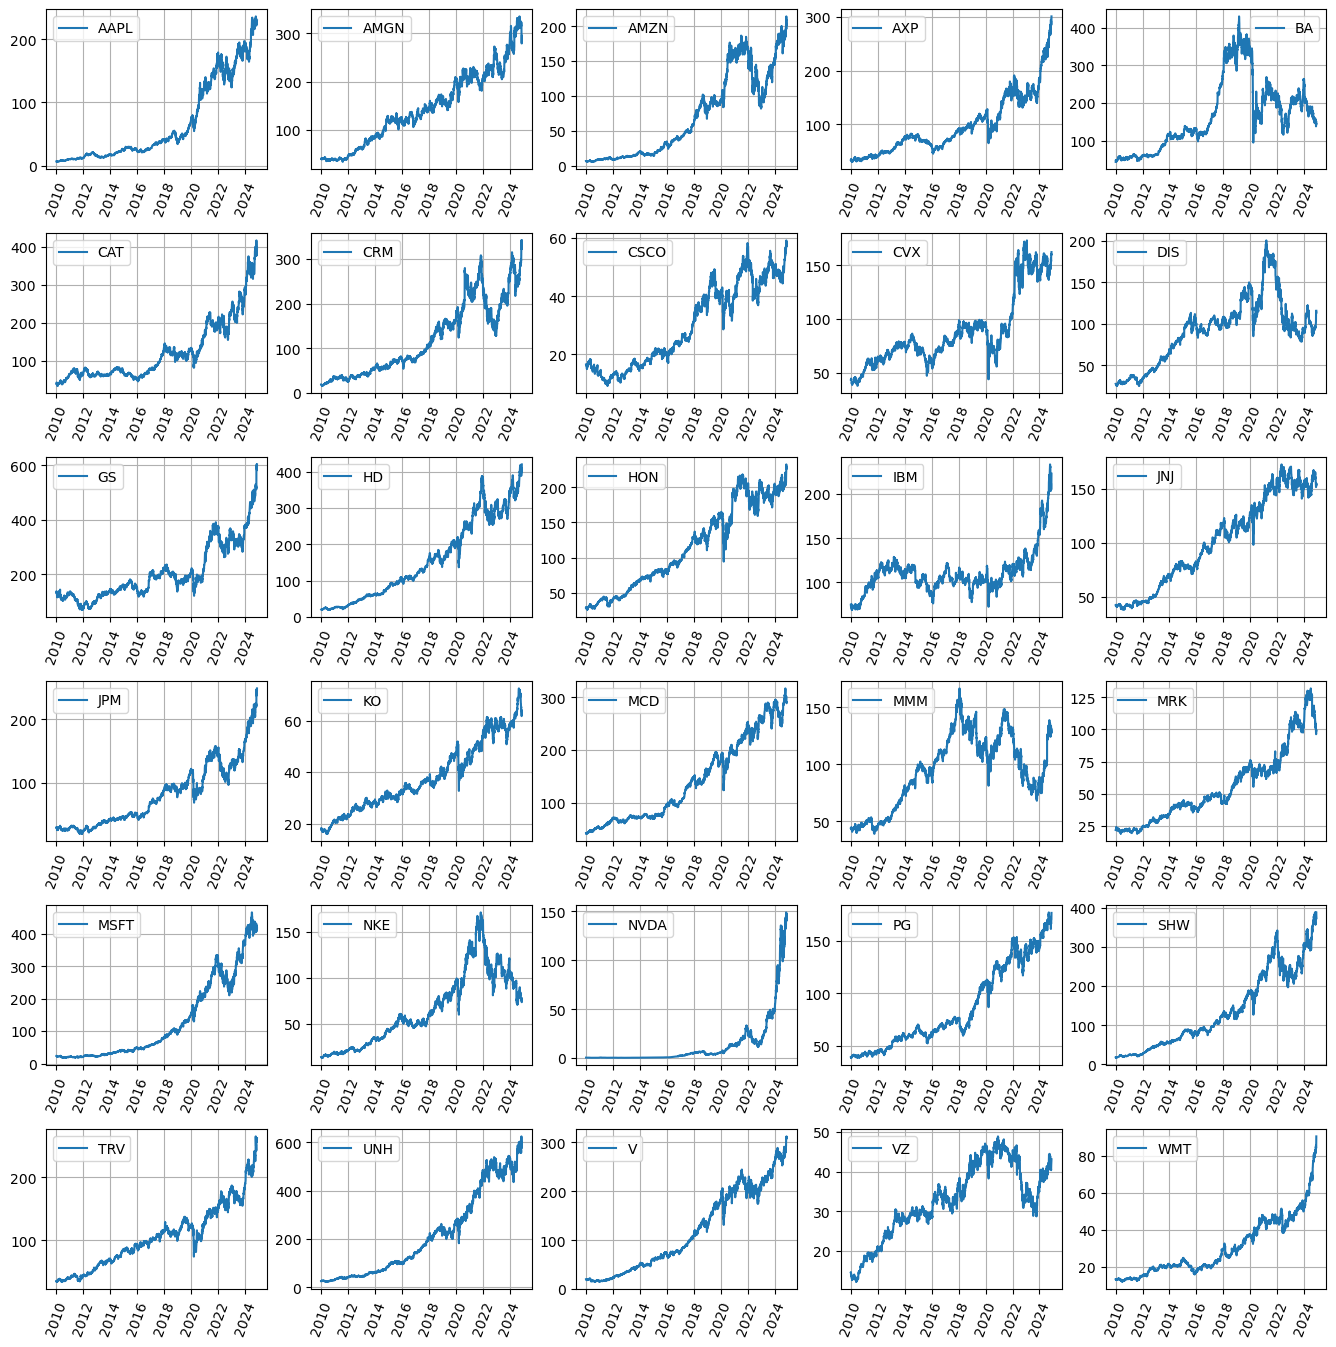

In [6]:
plt.figure(figsize=(16, 16)) 

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

for i in range(len(tickers)):
    plt.subplot(6,5,i+1)
    plt.grid()
    plt.plot(Dates,dowjones.iloc[:,i], label = dowjones.columns[i])
    plt.legend()
    plt.xticks(rotation=70)
plt.show()

I am using Berkshire Hathaway as an example as it does not pay any dividends and thus the prices do not need any adjustments in that direction. 

Let me illustrate the Merton's portfolio optimization on this stock. 

In [7]:
brk = yf.Ticker('BRK-A')

data = yf.download('BRK-A',start='2010-01-03')['Close']

data

[*********************100%***********************]  1 of 1 completed


Date
2010-01-04     99600.0
2010-01-05     99710.0
2010-01-06     99850.0
2010-01-07    100000.0
2010-01-08    100300.0
                ...   
2024-11-18    708000.0
2024-11-19    703960.0
2024-11-20    703300.0
2024-11-21    707250.0
2024-11-22    714280.0
Name: Close, Length: 3749, dtype: float64

Extract Dates for plotting purposes.

In [8]:
Dates = pd.to_datetime(data.index, format='%Y-%m-%d')

And here is the plot of the price.

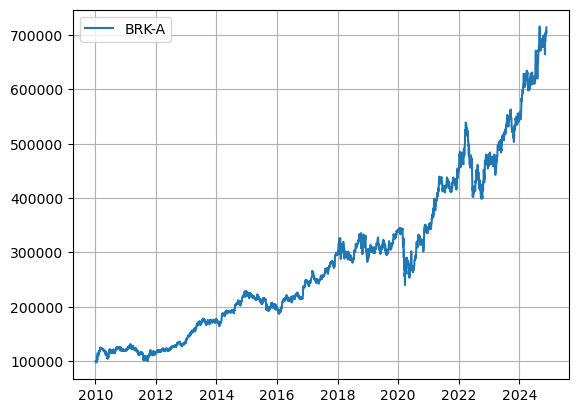

In [9]:
plt.figure()
plt.grid()
plt.plot(Dates,data, label = "BRK-A")
plt.legend()
plt.show()

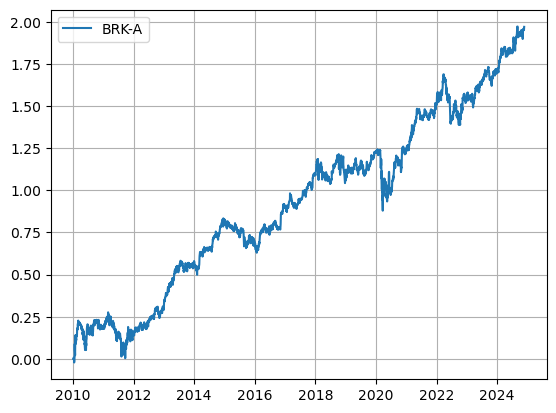

In [10]:
plt.figure()
plt.grid()
plt.plot(Dates,np.log(data) - np.log(data[0]), label = "BRK-A")
plt.legend()
plt.show()

Extract time horizon T in years.

In [11]:
from datetime import date

d0 = Dates[0]
d1 = Dates[data.shape[0]-1]
delta = d1 - d0
T = delta.days/365.25
T

14.882956878850102

Construct vector time that corresponds to daily observations (expressed in years).

In [12]:
sampling_points = data.shape[0]-1
dt = T/sampling_points
time = np.linspace(0,T,sampling_points+1)

Observations per year.

In [13]:
len(time)/T

251.89886865342163

Total number of observations.

In [14]:
len(time)

3749

Compute simple returns.

In [15]:
simplereturns = data.pct_change(1)

In [16]:
simplereturns.iloc[0] = 0

Annualized volatility.

In [17]:
sigmaQ = simplereturns.std()*np.sqrt(252)

In [18]:
sigmaQ

0.18811533677217251

In [19]:
simplereturns.std()

0.01185015235467458

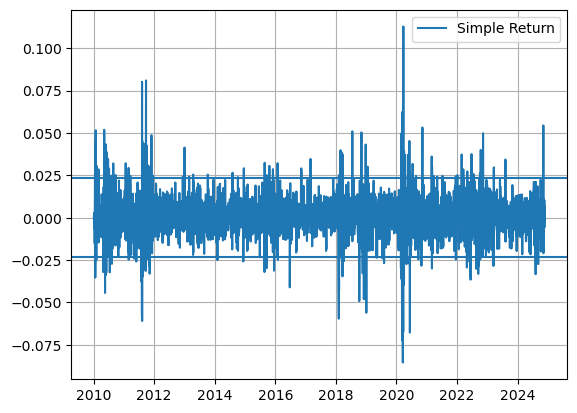

In [20]:
plt.figure()
plt.grid()
plt.plot(Dates,simplereturns, label = "Simple Return")
plt.axhline(1.96*simplereturns.std())
plt.axhline(-1.96*simplereturns.std())
plt.legend()
plt.show()

In [21]:
above = (simplereturns> 1.96*simplereturns.std())

In [22]:
np.sum(above)/len(above)

0.029074419845292077

In [23]:
logreturns = data.apply(np.log).diff()

In [24]:
logreturns[0] = 0

In [25]:
dflog = logreturns.cumsum()

The volatility should be observed outside the trading period (i.e., prior to 2010), but this parameter is relatively stable, so we just take it as it is. However, you should do it correctly, meaning get it from dates prior to 2010.

This is the simple return process R(t). I call it dfbrown, indicating that it should be a Brownian motion. It should behave like a random walk. The market prices this process with zero drift.

In [26]:
dfbrown = simplereturns.cumsum()

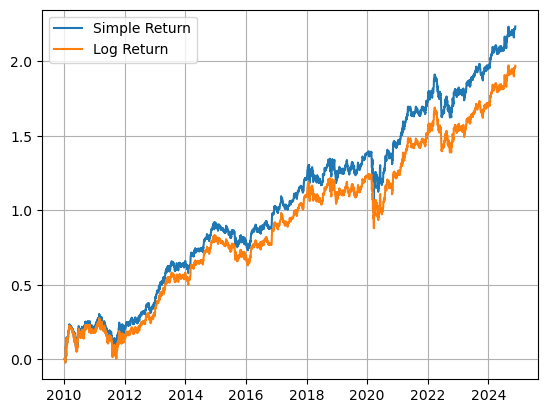

In [27]:
plt.figure()
plt.grid()
plt.plot(Dates,dfbrown, label = "Simple Return")
plt.plot(Dates,dflog, label = "Log Return")

plt.legend()
plt.show()

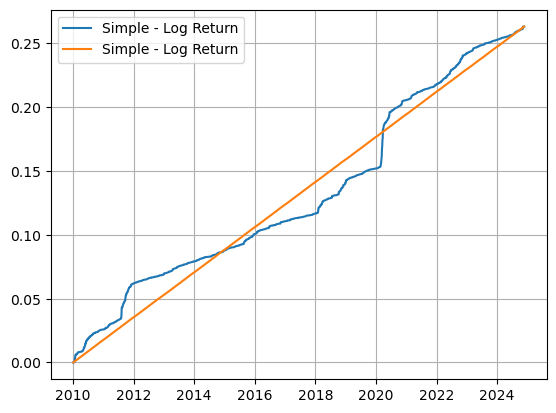

In [28]:
plt.figure()
plt.grid()
plt.plot(Dates,dfbrown-dflog, label = "Simple - Log Return")
plt.plot(Dates,time*sigmaQ**2/2, label = "Simple - Log Return")
plt.legend()
plt.show()

### Statistical understanding of returns.

A driftless assumption can be statistically tested H0: mu = 0 vs H1: mu > 0. Under the assumption of the driftless market, the confidence interval for the upper limit of the simple return process R(t) is normalquantile.sigmaQ.sqrt(t), which is in this example violated on both 95 and 99 confidence levels.

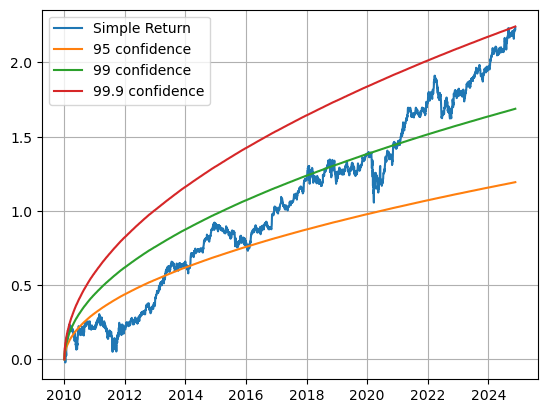

In [29]:
plt.figure()
plt.grid()
plt.plot(Dates,dfbrown, label = "Simple Return")
plt.plot(Dates,sp.norm.ppf(0.95)*sigmaQ*np.sqrt(time), label = "95 confidence")
plt.plot(Dates,sp.norm.ppf(0.99)*sigmaQ*np.sqrt(time), label = "99 confidence")
plt.plot(Dates,sp.norm.ppf(0.999)*sigmaQ*np.sqrt(time), label = "99.9 confidence")

plt.legend()
plt.show()

Just to be clear - the violation of the driftless hypothesis is visible only ex post.

Can we capitalize the drift? This requires a choice of the parameter mu.

A typical approach is to estimate the parameter mu from the historical data (in our case prior to 2010). I chose 5 year window (again completely ad hoc choice).

In [30]:
estimation = brk.history(start='2005-01-01', end = '2010-01-01')['Close']
estimation

Date
2004-12-31    87900.0
2005-01-03    87100.0
2005-01-04    85901.0
2005-01-05    85700.0
2005-01-06    86192.0
               ...   
2009-12-24    98895.0
2009-12-28    98530.0
2009-12-29    98550.0
2009-12-30    98700.0
2009-12-31    99200.0
Name: Close, Length: 1260, dtype: float64

This extract simple returns and sum them up.

In [31]:
estreturns = estimation.pct_change(1)
estreturns[0] = 0
estbrown = estreturns.cumsum()

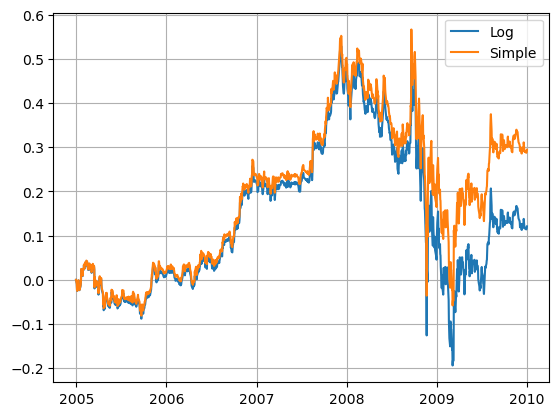

In [32]:
plt.figure()
plt.plot(np.log(estimation) - np.log(estimation[0]), label = 'Log')
plt.plot(estbrown, label = 'Simple')
plt.legend()
plt.grid()
plt.show()

In [33]:
(estreturns.std()*np.sqrt(252))**2/2

0.03521030721885763

In [34]:
#sigmaQ = (estreturns.std()*np.sqrt(252))

The last value corresponds to mu.t, so the estimator of mu is the last value divided by the time interval.

In [35]:
estbrown[-1]/5

0.05888041601756473

Around 6%. Note that this is much smaller than the performance over 2010 - 2023. But we could not know. Let's put 6%.

In [36]:
mu = 0.06

The ex post performance nearly rejects this drift as too small.

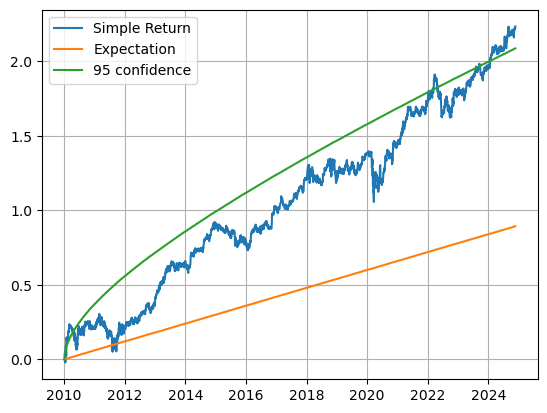

In [37]:
plt.figure()
plt.grid()
plt.plot(Dates,dfbrown, label = "Simple Return")
plt.plot(Dates,time*mu, label = "Expectation")
plt.plot(Dates,time*mu + sp.norm.ppf(0.95)*sigmaQ*np.sqrt(time), label = "95 confidence")

plt.legend()
plt.show()

### Optimal portfolio, dynamic setup

Optimal portfolio price as a likelihood ratio. The core function.

In [38]:
def merton(X,mu,sigmaQ,t):
    return sp.norm.pdf(X,mu*t, sigmaQ*np.sqrt(t))/sp.norm.pdf(X,0,sigmaQ*np.sqrt(t))

Position in the risky asset (Merton's fraction). This is the relative percentage invested in that asset (in this case the position is leveraged), the absolute position is dynamic.

In [39]:
mu/sigmaQ**2

1.6955197056277715

Expected log return of Merton's portfolio from the agent's perspective.

In [40]:
(mu/sigmaQ)**2*T/2

0.7570303999829622

In [41]:
mu = 0.06

The optimal portfolio evolution.

In [42]:
Merton = np.empty(len(time))

In [43]:
Merton[0]=1
for i in range(1,len(time)):
    Merton[i] = merton(dfbrown[i],mu,sigmaQ,time[i])

Convert array to series.

In [44]:
Merton = pd.Series(Merton)

Define the asset price normalized to 1.

In [45]:
BRK = data/data.iloc[0]

Performance of the portfolio vs performance of an asset.

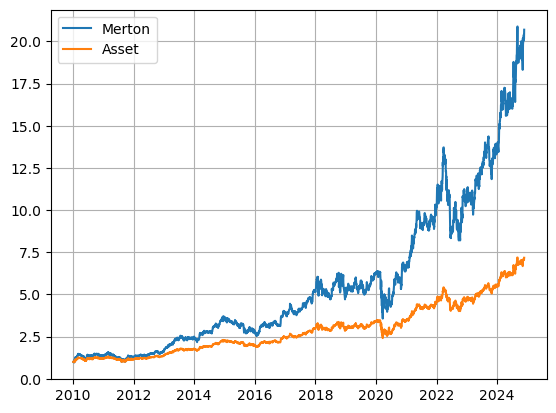

In [46]:
plt.figure()
plt.grid()
plt.plot(Dates, Merton, label = "Merton")
plt.plot(Dates, BRK, label = "Asset")
plt.legend()
plt.show()

In [186]:
Ratio = Merton.values/BRK.values

In [187]:
Ratio

array([1.        , 1.00056693, 1.00134323, ..., 2.85537984, 2.86602173,
       2.8854631 ])

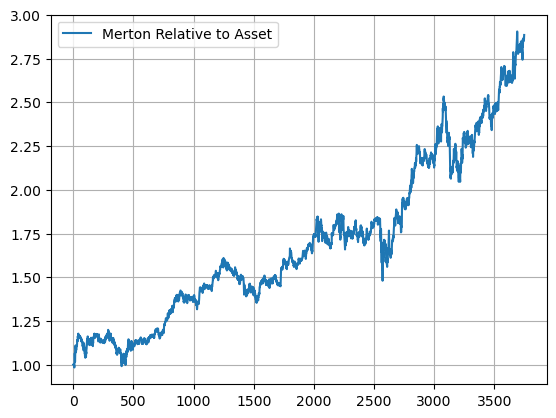

In [188]:
plt.figure()
plt.grid()
plt.plot(Merton.values/BRK.values, label = "Merton Relative to Asset")
plt.legend()
plt.show()

Realized log return.

In [47]:
np.log(Merton.iloc[-1])

3.0297982848754863

Beats the expectation.

### Replication

Merton's portfolio corresponds to a theoretical price, it is not clear if there is an asset in the economy that would match this price. This is a question of replication. Replication works on the assumption of the constant market parameters, changes of the parameters may lead to divergence of the replicating portfolio.

In [48]:
Replication = np.empty(sampling_points+1, dtype=float)

In [49]:
Replication[0] = 1

In [50]:
for j in range(sampling_points):
    Replication[j+1] = Replication[j] + (mu/sigmaQ**2)* Replication[j]*simplereturns.iloc[j+1]

The match of the theoretical price and the replicating portfolio looks pretty good.

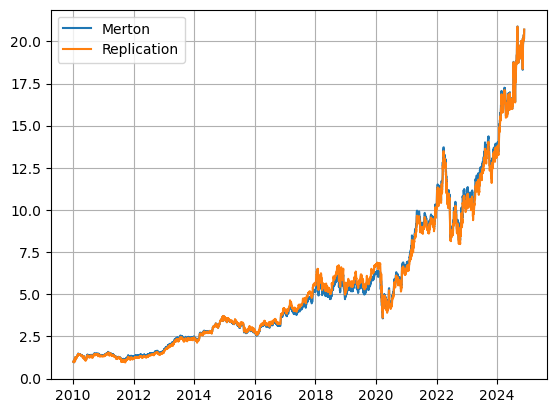

In [51]:
plt.figure()
plt.grid()
plt.plot(Dates, Merton, label = "Merton")
plt.plot(Dates, Replication , label = "Replication")
plt.legend()
plt.show()

### Static Portfolio

The alternative mainstream approach to portfolio optimization is based on mean variance analysis (Markowitz). It determines static positions in the assets. In our particular case with one risky and one riskless asset, the optimal fraction invested in the risky asset is given by the following function.

In [52]:
def w(mu,sigma,t):
    return (np.exp((mu**2*t)/sigma**2) - np.exp((mu*(mu + sigma**2)*t)/sigma**2))/(2*np.exp((mu**2*t)/sigma**2) - np.exp((mu*(mu + sigma**2)*t)/sigma**2) - np.exp((-mu + mu**2/sigma**2 + sigma**2)*t))

For our paramters, we get:

In [53]:
w(mu,sigmaQ,T)

1.270068364223127

Markowitz approximates the expected log return. In the normal distribution, static portfolios may expire negative when leveraged above 1 and thus the position for log utility maximizer is bounded by one.  However, the mean variance approximation of the log function goes well into the leveraged region, but the problem still gives more conservative values in comparison to Merton.

The fraction w is invested in the risky asset. The residual wealth (1-w) goes to the riskless asset. Static portfolios are alredy self replicating.

In [54]:
Markowitz = BRK*w(mu,sigmaQ,T) + (1 - w(mu,sigmaQ,T))

Comparison. The dynamic portfolio performs better in this case due to the large realized drift. The relative position eventually invests more in the absolute numbers, thus outperforming the fixed absolute position. The story may be different for different stocks.

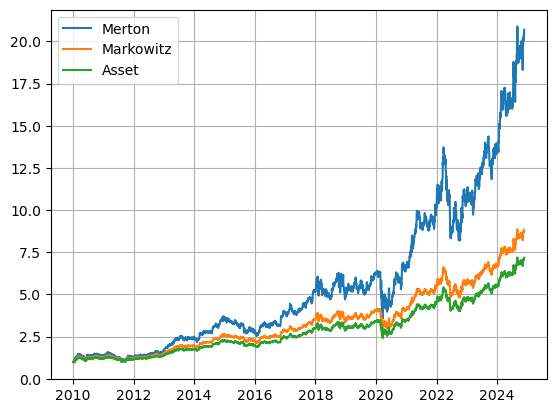

In [55]:
plt.figure()
plt.grid()
plt.plot(Dates, Merton, label = "Merton")
plt.plot(Dates, Markowitz, label = "Markowitz")
plt.plot(Dates, BRK, label = "Asset")
plt.legend()
plt.show()

### Performance Statistics

Various performance statistics.

In [56]:
def sharpe(prices):
    returns = prices.pct_change(1)
    mu = np.mean(returns)*252
    sigma = np.std(returns)*np.sqrt(252)
    return mu/sigma

Sharpe ratios for the asset, dynamic Merton's portfolio and static Markowitz portfolio.

In [57]:
sharpe(BRK)

0.7982698327372548

In [58]:
sharpe(Merton)

0.7957092032654125

In [59]:
sharpe(Markowitz)

0.7995657168310473

Seems very similar, it could be for the reason that scaling the investment position scales both the mean and the variance proportionally, leaving the Sharpe ratio intact. This would be the case of the asset vs Merton's portfolio. Markowitz can be off. I will think about it, but you should check the performace statistcs for your stocks regardless of this observation.

Another performance statistics is maximal (relative) drawdown, the largest percentage drop of the price evolution.

In [60]:
def max_drawdown(prices):
    a = np.maximum.accumulate(prices)
    return np.max(1 - prices/a)

Here are the drawdowns. Merton has the most dramatic drop as also visible in the graph.

In [61]:
max_drawdown(BRK)

0.3042873293329854

In [62]:
max_drawdown(Merton)

0.4415842654771124

In [63]:
max_drawdown(Markowitz)

0.3241906290217341

### Consequences of excessive leverage

Empirical facts. The Merton's portfolio will converge to infinity as long as the chosen parameter by the agent is closer to the true value in comparison to the driftless risk neutral measure. In particular, when the true drift is positive, the agent must choose mu in the interval (0, 2.true_mu). Above that, the agent has an excessive leverage.

In [64]:
def mean(prices):
    returns = prices.pct_change(1)
    mu = np.mean(returns)*252
    return mu

In [65]:
mean(BRK)

0.15016674777653255

The true mu (observed ex post) is approximately 14%. This means choosing mu either below zero, or above 28% would collapse the fund. The more extreme values will lead to a faster bankruptcy.

The next cell chooses various parameters. The values mu = -0.1 and mu = 0.4 are by comparison about 10 percent off in comparison to the risk neutral measure and are expected to tank quickly. The values mu = -0.01 and mu = 0.3 are just sligtly off, meaning they will go to zero, but not too dramatically. The value corresponding to mu = 0.14 is about the best portfolio one could get (but known only in retrospect). 

Generate the funds for various values of mu. This can be probably done more elegantly using dataframes.

In [66]:
MertonM10 = np.empty(len(time))
MertonM10[0]=1
for i in range(1,len(time)):
    MertonM10[i] = merton(dfbrown[i],-0.1,sigmaQ,time[i])

MertonM1 = np.empty(len(time))
MertonM1[0]=1
for i in range(1,len(time)):
    MertonM1[i] = merton(dfbrown[i],-0.01,sigmaQ,time[i])

Merton14 = np.empty(len(time))
Merton14[0]=1
for i in range(1,len(time)):
    Merton14[i] = merton(dfbrown[i],0.14,sigmaQ,time[i])
    
Merton30 = np.empty(len(time))
Merton30[0]=1
for i in range(1,len(time)):
    Merton30[i] = merton(dfbrown[i],0.3,sigmaQ,time[i])

    
Merton40 = np.empty(len(time))
Merton40[0]=1
for i in range(1,len(time)):
    Merton40[i] = merton(dfbrown[i],0.4,sigmaQ,time[i])

The graph confirms the previous discussion. Log scale.

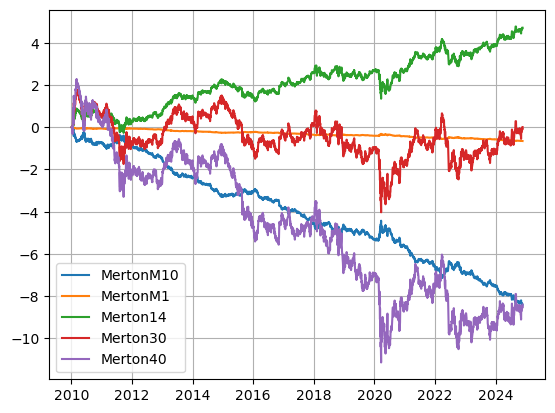

In [67]:
plt.figure()
plt.grid()
plt.plot(Dates, np.log(MertonM10), label = "MertonM10")
plt.plot(Dates, np.log(MertonM1), label = "MertonM1")
plt.plot(Dates, np.log(Merton14), label = "Merton14")
plt.plot(Dates, np.log(Merton30), label = "Merton30")
plt.plot(Dates, np.log(Merton40), label = "Merton40")
plt.legend()
plt.show()

### Model Diversification, Bayesian Approach

In order to prevent a wrong pick of the parameterm mu, one can diversify it in Merton's portfolio problem. The assumption is that the parameter mu itself is random with distribution N(mu0, sigma0^2). One can view it as having infinitely many funds, each of them with the initial endowment proportion to the N(mu0, sigma0^2) distribution known as the prior. The fund value corresponds to the integrated value of individual funds and it is given by the following function.

In [68]:
def merton_bayes(sigma, mu0, s0, stock0, simple_return, time):
    return stock0*np.exp((s0**2*simple_return**2  + 2*mu0*simple_return*sigma**2 - mu0**2*sigma**2*time)/(2*sigma**2*(sigma**2+s0**2*time)))/(np.sqrt(1+s0**2/sigma**2*time))

The advantage of this approach is that it self corrects automatically especially when the chosen parameter is off. For instance if we assume a small negative drift, we know that the fund would collapse. However, adding an uncertainty parameter sigma0, the resulting confidence interval will pick the values closer to the true parameter. The disadvantage is that the diversification leads also to a choice of bad parameters corresponding to funds that will bankrupt. However, it is enough to pick some of them that will converge to infinity. In reality, the convergence to infinity may take very long time (horizons of hundreds of years).

Let us pick parameters that are off. This part is educational, the reasonable parameters are again 6% used later.

In [69]:
mu0 = -0.01
sigma0 = 0.08

The 95% funds are distributed to values from (-0.17, 0.15). Basically half of the money is wasted on negative parameters, but the other half goes to infinity.

Compare the performance of the Bayes portfolio with Merton 6%, Merton 14% and Merton -1% portfolios. The Bayes starts with tracking the Merton -1% portfolio as this is the initial guess and thus the first 2-3 years it almost looks identical. However, the part of the diversification portfolios in Bayes that correspond to larger values get more significant (these funds will have more money) and they will start to dominate the system. Bayes will visibly start to track to true portfolio Merton14, so it is just a question of time when it beats Merton6. It takes some time to do so. However, you have the guarantee that you are tracking the true parameter, but the cost is that the diversification means that part of the funds was sacrificed on wrong values. Log scale for better comparison.

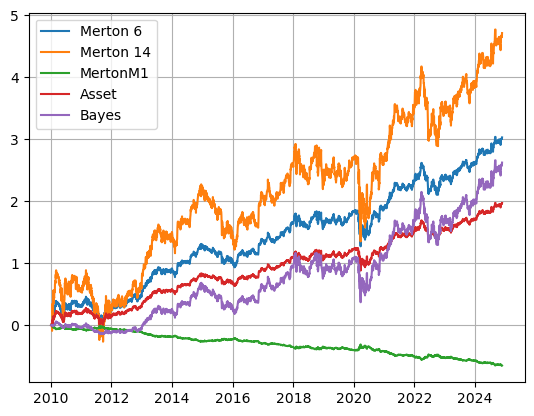

In [70]:
plt.figure()
plt.plot(Dates,np.log(Merton), label = "Merton 6")
plt.plot(Dates,np.log(Merton14), label = "Merton 14")
plt.plot(Dates,np.log(MertonM1), label = "MertonM1")
plt.plot(Dates,np.log(BRK/BRK[0]), label = 'Asset')
plt.plot(Dates, np.log(merton_bayes(sigmaQ,mu0,sigma0,1,dfbrown,time)), label = "Bayes")
plt.legend()
plt.grid()
plt.show()

### Reasonable parameters and replication

Now let's get back to reasonable parameters.

In [71]:
mu0 = 0.06
sigma0 = 0.08

95% of the funds go to (-0.1, 0.22). Some funds will be lost on negative values, but the performance will be boosted by higher drifts that are closer to reality.

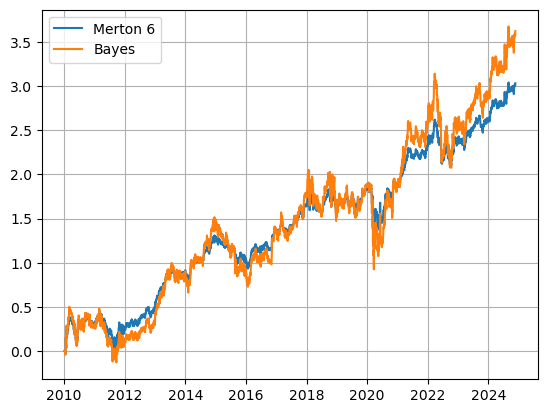

In [72]:
plt.figure()
plt.plot(Dates, np.log(Merton), label = "Merton 6")
plt.plot(Dates, np.log(merton_bayes(sigmaQ,mu0,sigma0,1,dfbrown,time)), label = "Bayes")
plt.legend()
plt.grid()
plt.show()

Bayes portfolio outperforms Merton's portfolio with 6% drift.

The replication of Bayes portfolio is similar to Merton's, the fraction invested in the ristky asset is mu/sigma^2, except the mu parameter is now dynamically updated and it corresponds to the posterior mean. In the limit, it is the running average.

In [73]:
def posteriormean(m0,sigma0,sigma,x,time):
    return (m0/sigma0**2 + x/sigma**2)/(1/sigma0**2+time/sigma**2)

Graph of the posterior mean for Berkshire Hathaway.

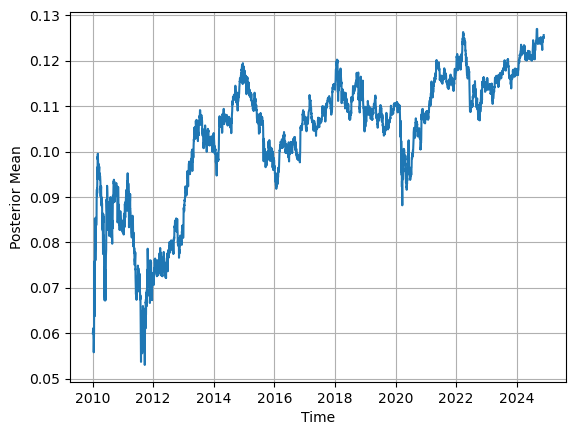

In [74]:
plt.figure()

plt.plot(Dates,posteriormean(mu,0.08,sigmaQ,dfbrown,time))
plt.grid()
plt.xlabel('Time')
plt.ylabel('Posterior Mean')
plt.show()

Note that the posterior mean is still influenced by the prior mean 6% after about 14 years of observations.

In [75]:
Bayes = np.empty(sampling_points+1, dtype=float)

Bayes[0] = 1

for j in range(sampling_points):
    Bayes[j+1] = Bayes[j] +  (posteriormean(mu0,sigma0,sigmaQ,dfbrown,time)[j]/sigmaQ**2)*(simplereturns.iloc[j+1])*Bayes[j]

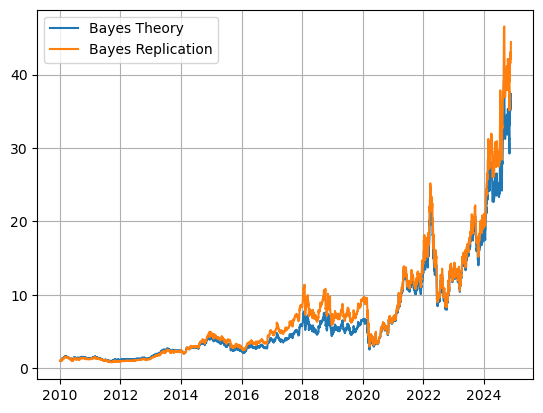

In [76]:
plt.figure()
plt.plot(Dates, merton_bayes(sigmaQ,mu0,sigma0,1,dfbrown,time), label = "Bayes Theory")
plt.plot(Dates, Bayes, label = "Bayes Replication")
plt.legend()
plt.grid()
plt.show()

Similar quality fit to the fixed mu.

Peformance of Bayes portfolio.

In [77]:
sharpe(merton_bayes(sigmaQ,mu0,sigma0,1,dfbrown,time))

0.721585737933309

It has a substantial drawdown. There is no control on that that would be inherent to statistics. 

In [78]:
max_drawdown(merton_bayes(sigmaQ,mu0,sigma0,1,dfbrown,time))

0.6743420798114004

The Sharpe ratio and max drawdown have similar values, but this time this is just a pure coincidence.

If the agent does not like it, she may stick to more conservative values. This means small drift and small variance. Try

In [79]:
mu0 = 0.04
sigma0 = 0.01

In [80]:
sharpe(merton_bayes(sigmaQ,mu0,sigma0,1,dfbrown,time))

0.7945228120640402

In [81]:
max_drawdown(merton_bayes(sigmaQ,mu0,sigma0,1,dfbrown,time))

0.3354947518751126

This corresponds to risk aversion, both performance statistics improved. All the agent needs to do is to stay closer to the zero drift and that's it. What I am saying is that method described in this text is universal, it is the agent's matter of preference which parameters to choose. 

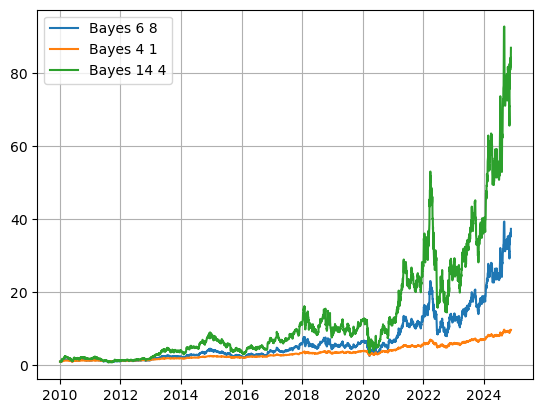

In [82]:
plt.figure()
plt.plot(Dates, merton_bayes(sigmaQ,0.06,0.08,1,dfbrown,time), label = "Bayes 6 8")
plt.plot(Dates, merton_bayes(sigmaQ,0.04,0.01,1,dfbrown,time), label = "Bayes 4 1")
plt.plot(Dates, merton_bayes(sigmaQ,0.14,0.04,1,dfbrown,time), label = "Bayes 14 4")

plt.legend()
plt.grid()
plt.show()

But that's what you get. Bayes 4 2 is less risky, but you may want Bayes 6 8. 

# Part 2: Portfolio Optimization Based on Volatility

### Getting and Visualizing Data

In [83]:
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO

import ssl
import certifi

In [163]:
context = ssl.create_default_context(cafile=certifi.where())

# URL of the ZIP file containing the CSV
url = "https://www.ecb.europa.eu/stats/eurofxref/eurofxref-hist.zip"

# Open the URL and read the contents into memory
with urlopen(url, context=context) as response:
    # Open the ZIP file from the response
    with ZipFile(BytesIO(response.read())) as myzip:
        # Assuming 'eurofxref-hist.csv' is the target file name
        with myzip.open('eurofxref-hist.csv') as myfile:
            # Read the CSV file directly into pandas DataFrame
            df = pd.read_csv(myfile)

# Now 'df' contains the data from 'eurofxref-hist.csv', without explicitly saving the ZIP or CSV file


In [164]:
df1 = df

In [165]:
df1.head()

,Date,USD,JPY,BGN,CYP,CZK,DKK,EEK,GBP,HUF,...,INR,KRW,MXN,MYR,NZD,PHP,SGD,THB,ZAR,Unnamed: 42
0,2024-11-22,1.0412,160.84,1.9558,NaN,25.358,7.4577,NaN,0.83205,411.13,...,87.9290,1464.43,21.2742,4.6516,1.7824,61.368,1.4034,35.968,18.7942,NaN
1,2024-11-21,1.0526,162.53,1.9558,NaN,25.346,7.4588,NaN,0.83273,410.50,...,88.9158,1471.60,21.4444,4.6999,1.7924,62.116,1.4144,36.467,19.0284,NaN
2,2024-11-20,1.0562,164.42,1.9558,NaN,25.286,7.4592,NaN,0.83380,409.60,...,89.1025,1474.40,21.3036,4.7228,1.7947,62.282,1.4173,36.581,19.1266,NaN
3,2024-11-19,1.0578,162.71,1.9558,NaN,25.284,7.4591,NaN,0.83638,407.45,...,89.2935,1472.84,21.4956,4.7315,1.7949,62.314,1.4163,36.521,19.0970,NaN
4,2024-11-18,1.0552,163.74,1.9558,NaN,25.282,7.4591,NaN,0.83560,408.70,...,89.0765,1474.49,21.5023,4.7278,1.8062,61.929,1.4186,36.758,19.0768,NaN


Drop incomplete columns.

In [166]:
df1 = df.dropna(axis='columns')
df1 = df1[::-1]
df1 = df1.reset_index(drop=True)
#df1.insert(1, 'EUR', 1)

In [167]:
df1.head()

,Date,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
0,1999-01-04,1.1789,133.73,35.107,7.4501,0.71110,251.48,4.0712,9.4696,1.6168,8.8550,1.9100,1.8004,9.1332,1398.59,2.2229,1.9554,6.9358
1,1999-01-05,1.1790,130.96,34.917,7.4495,0.71220,250.80,4.0245,9.4025,1.6123,8.7745,1.8944,1.7965,9.1341,1373.01,2.2011,1.9655,6.7975
2,1999-01-06,1.1743,131.42,34.850,7.4452,0.70760,250.67,4.0065,9.3050,1.6116,8.7335,1.8820,1.7711,9.1010,1359.54,2.1890,1.9699,6.7307
3,1999-01-07,1.1632,129.43,34.886,7.4431,0.70585,250.09,4.0165,9.1800,1.6165,8.6295,1.8474,1.7602,9.0131,1337.16,2.1531,1.9436,6.8283
4,1999-01-08,1.1659,130.09,34.938,7.4433,0.70940,250.15,4.0363,9.1650,1.6138,8.5900,1.8406,1.7643,9.0302,1366.73,2.1557,1.9537,6.7855


Extract dates.

In [168]:
Dates = pd.to_datetime(df1['Date'], format='%Y-%m-%d')

In [169]:
df1 = df1.set_index('Date')

Total time in years.

In [170]:
from datetime import date

d0 = Dates[0]
d1 = Dates[df1.shape[0]-1]
delta = d1 - d0
T = delta.days/365.25
T

25.883641341546884

Observations per year (needed later for annualization of the parameters)

In [171]:
len(Dates)/T

256.262243494817

Set time grid.

In [172]:
sampling_points = df1.shape[0]-1
dt = T/sampling_points
time = np.linspace(0,T,sampling_points+1)

Sample graph EUR/USD exchange rate.

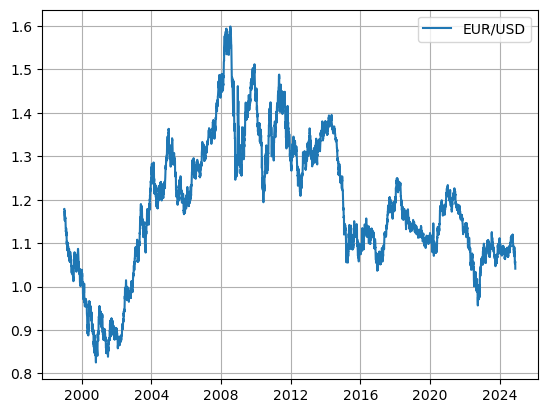

In [173]:
plt.figure()
plt.grid()
plt.plot(Dates,df1['USD'], label = "EUR/USD")
plt.legend()
plt.show()

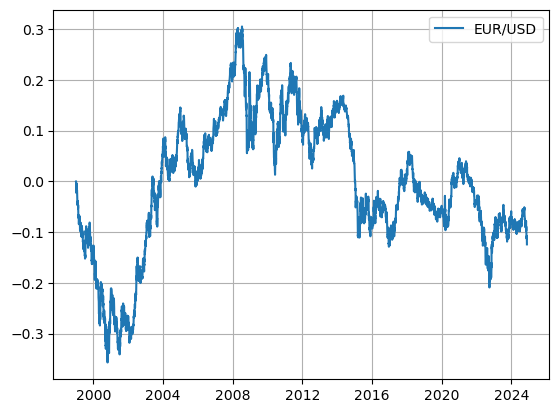

In [96]:
plt.figure()
plt.grid()
plt.plot(Dates,np.log(df1['USD']/df1['USD'].iloc[0]), label = "EUR/USD")
plt.legend()
plt.show()

The df1 dataset gives how many units of a foreign currency is needed for a unit of EUR. Thus the reference asset is the foreign currency. In order to make EUR the reference currency, we need to take the reciprocal exchange rate, which gives how many units of EUR is needed to acquire a unit of a foreign currency. The dataset will all be reference by the same underlying currency EUR.

In [97]:
def reciprocal(x):
    return 1/x

In [98]:
df2 = df1.apply(reciprocal)

In [99]:
df2.head()

,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
Date,,,,,,,,,,,,,,,,,
1999-01-04,0.848248,0.007478,0.028484,0.134226,1.406272,0.003976,0.245628,0.105601,0.618506,0.112931,0.523560,0.555432,0.109491,0.000715,0.449863,0.511404,0.144179
1999-01-05,0.848176,0.007636,0.028639,0.134237,1.404100,0.003987,0.248478,0.106355,0.620232,0.113967,0.527872,0.556638,0.109480,0.000728,0.454318,0.508776,0.147113
1999-01-06,0.851571,0.007609,0.028694,0.134315,1.413228,0.003989,0.249594,0.107469,0.620501,0.114502,0.531350,0.564621,0.109878,0.000736,0.456830,0.507640,0.148573
1999-01-07,0.859697,0.007726,0.028665,0.134353,1.416732,0.003999,0.248973,0.108932,0.618620,0.115882,0.541301,0.568117,0.110950,0.000748,0.464447,0.514509,0.146449
1999-01-08,0.857706,0.007687,0.028622,0.134349,1.409642,0.003998,0.247752,0.109111,0.619655,0.116414,0.543301,0.566797,0.110740,0.000732,0.463886,0.511849,0.147373


Sample graph, USD/EUR exchange rate. How may EUR are needed to get one USD.

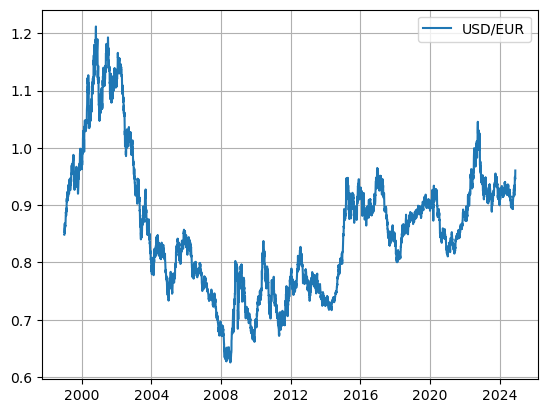

In [100]:
plt.figure()
plt.grid()
plt.plot(Dates,df2['USD'], label = "USD/EUR")
plt.legend()
plt.show()

All FX rates plotted at once.

In [101]:
import matplotlib.gridspec as gridspec

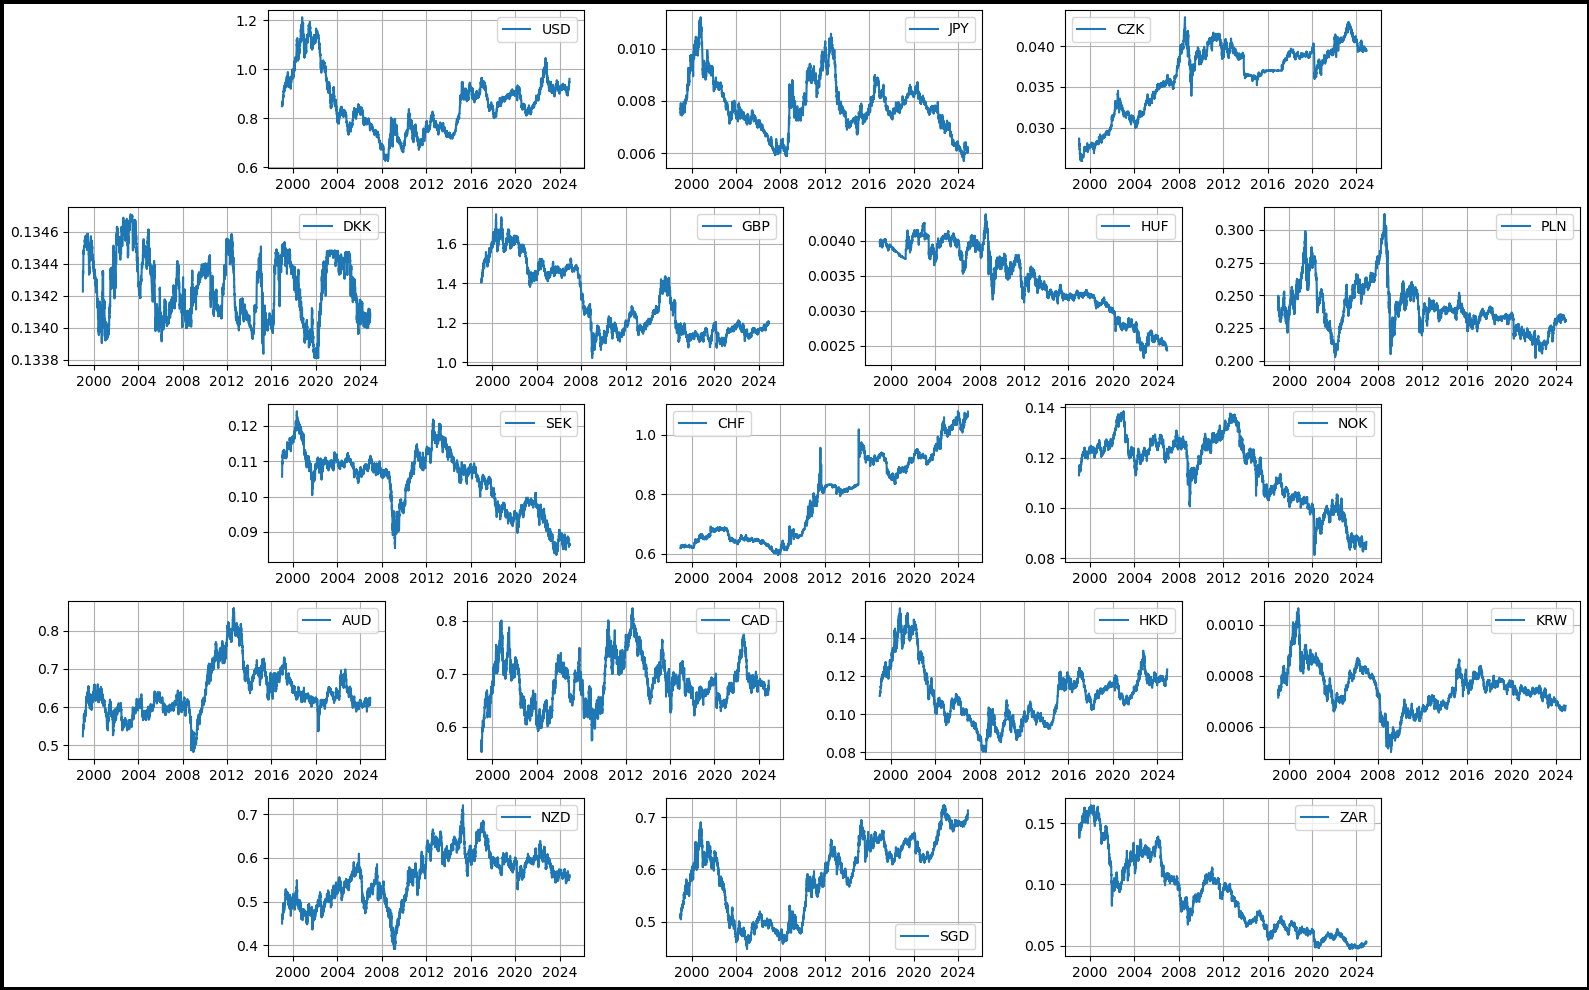

In [102]:
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(5, 8)

fig.subplots_adjust(top=0.85, bottom=0.15, left=0.2, hspace=0.8)

fig.patch.set_linewidth(5)
fig.patch.set_edgecolor('black')

for i in range(0,3):
    ax = plt.subplot(gs[0, 2 * i +1:2 * i + 3])
    plt.grid()
    plt.plot(Dates,df2.iloc[:,i], label = df2.columns[i])
    plt.legend()
    
for i in range(3, 7):
    ax = plt.subplot(gs[1, 2 * i - 6:2 * i + 2 - 6])
    plt.grid()
    plt.plot(Dates,df2.iloc[:,i], label = df2.columns[i])
    plt.legend()

for i in range(7, 10):
    ax = plt.subplot(gs[2, 2 * i - 13:2 * i + 2 - 13])
    plt.grid()
    plt.plot(Dates,df2.iloc[:,i], label = df2.columns[i])
    plt.legend()     
    
for i in range(10, 14):
    ax = plt.subplot(gs[3, 2 * i - 20:2 * i + 2 - 20])
    plt.grid()
    plt.plot(Dates,df2.iloc[:,i], label = df2.columns[i])
    plt.legend()
 
for i in range(14, 17):
    ax = plt.subplot(gs[4, 2 * i - 27:2 * i + 2 - 27])
    plt.grid()
    plt.plot(Dates,df2.iloc[:,i], label = df2.columns[i])
    plt.legend()
    
plt.tight_layout()
plt.show()

Get log returns.

In [103]:
logreturns = df2.apply(np.log).diff()

In [104]:
logreturns.iloc[0] = 0

In [105]:
logreturns.head()

,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
Date,,,,,,,,,,,,,,,,,
1999-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1999-01-05,-0.000085,0.020931,0.005427,0.000081,-0.001546,0.002708,0.011537,0.007111,0.002787,0.009132,0.008201,0.002169,-0.000099,0.018459,0.009855,-0.005152,0.020142
1999-01-06,0.003994,-0.003506,0.001921,0.000577,0.006480,0.000518,0.004483,0.010424,0.000434,0.004684,0.006567,0.014240,0.003630,0.009859,0.005512,-0.002236,0.009876
1999-01-07,0.009497,0.015258,-0.001032,0.000282,0.002476,0.002316,-0.002493,0.013525,-0.003036,0.011980,0.018556,0.006173,0.009705,0.016598,0.016536,0.013441,-0.014397
1999-01-08,-0.002318,-0.005086,-0.001489,-0.000027,-0.005017,-0.000240,-0.004918,0.001635,0.001672,0.004588,0.003688,-0.002327,-0.001895,-0.021873,-0.001207,-0.005183,0.006288


Integrated log returns.

In [106]:
dflog = logreturns.cumsum()

Same for simple returns. Log returns are important for utility maximization, but the simple returns are needed for trading (linear contract on the difference).

In [107]:
simplereturns = df2.pct_change(1)

In [108]:
simplereturns.iloc[0] = 0

In [109]:
simplereturns.head()

,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
Date,,,,,,,,,,,,,,,,,
1999-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1999-01-05,-0.000085,0.021151,0.005441,0.000081,-0.001545,0.002711,0.011604,0.007136,0.002791,0.009174,0.008235,0.002171,-0.000099,0.018631,0.009904,-0.005139,0.020346
1999-01-06,0.004002,-0.003500,0.001923,0.000578,0.006501,0.000519,0.004493,0.010478,0.000434,0.004695,0.006589,0.014341,0.003637,0.009908,0.005528,-0.002234,0.009925
1999-01-07,0.009543,0.015375,-0.001032,0.000282,0.002479,0.002319,-0.002490,0.013617,-0.003031,0.012052,0.018729,0.006192,0.009752,0.016737,0.016674,0.013532,-0.014293
1999-01-08,-0.002316,-0.005073,-0.001488,-0.000027,-0.005004,-0.000240,-0.004905,0.001637,0.001673,0.004598,0.003694,-0.002324,-0.001894,-0.021636,-0.001206,-0.005170,0.006308


Simple return process R(t) (integrated simple returns).

In [110]:
dfbrown = simplereturns.cumsum()

In [111]:
dfbrown

,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
Date,,,,,,,,,,,,,,,,,
1999-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1999-01-05,-0.000085,0.021151,0.005441,0.000081,-0.001545,0.002711,0.011604,0.007136,0.002791,0.009174,0.008235,0.002171,-0.000099,0.018631,0.009904,-0.005139,0.020346
1999-01-06,0.003918,0.017651,0.007364,0.000658,0.004956,0.003230,0.016097,0.017615,0.003225,0.013869,0.014824,0.016512,0.003538,0.028538,0.015432,-0.007372,0.030270
1999-01-07,0.013460,0.033026,0.006332,0.000940,0.007436,0.005549,0.013607,0.031231,0.000194,0.025921,0.033553,0.022705,0.013291,0.045275,0.032105,0.006159,0.015977
1999-01-08,0.011144,0.027953,0.004844,0.000913,0.002431,0.005309,0.008701,0.032868,0.001867,0.030519,0.037247,0.020381,0.011397,0.023640,0.030899,0.000990,0.022285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-18,0.226038,-0.031317,0.368268,-0.001133,-0.081933,-0.392115,0.037066,-0.148565,0.600990,-0.198000,0.292635,0.309816,0.219458,0.105740,0.356334,0.393641,-0.714101
2024-11-19,0.223580,-0.024987,0.368189,-0.001133,-0.082866,-0.389047,0.036489,-0.147184,0.604742,-0.193068,0.298046,0.312513,0.217089,0.106861,0.362630,0.395265,-0.715159
2024-11-20,0.225095,-0.035387,0.368110,-0.001146,-0.079772,-0.394296,0.036374,-0.148994,0.603350,-0.191737,0.300450,0.316983,0.218634,0.105802,0.362741,0.394560,-0.716706


Annualized covariance matrix.

In [112]:
covmatrix = simplereturns.cov()*256.25
covmatrix

,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
USD,0.008907,0.006092,-0.000340,0.000026,0.003156,-0.001519,-0.000051,-0.000024,0.001186,0.000206,0.002430,0.005207,0.008800,0.005451,0.002147,0.005908,0.002393
JPY,0.006092,0.013262,-0.000479,0.000019,0.001995,-0.002187,-0.001159,-0.000497,0.002534,-0.000345,0.000914,0.002921,0.006039,0.003730,0.001244,0.004972,0.000510
CZK,-0.000340,-0.000479,0.003083,0.000003,0.000238,0.001750,0.001889,0.000652,-0.000156,0.000784,0.000649,0.000427,-0.000323,0.000315,0.000566,0.000101,0.001651
DKK,0.000026,0.000019,0.000003,0.000006,0.000014,-0.000004,0.000005,0.000008,0.000012,0.000014,0.000014,0.000027,0.000025,0.000023,0.000011,0.000019,0.000019
GBP,0.003156,0.001995,0.000238,0.000014,0.006128,0.000145,0.001079,0.000825,0.000467,0.001448,0.002922,0.003208,0.003145,0.003205,0.002865,0.002761,0.002805
HUF,-0.001519,-0.002187,0.001750,-0.000004,0.000145,0.007211,0.003932,0.001400,-0.000986,0.001461,0.001745,0.000672,-0.001499,0.000726,0.001491,-0.000290,0.003807
PLN,-0.000051,-0.001159,0.001889,0.000005,0.001079,0.003932,0.007575,0.001572,-0.000747,0.001749,0.002468,0.002036,-0.000020,0.002113,0.002125,0.000951,0.004662
SEK,-0.000024,-0.000497,0.000652,0.000008,0.000825,0.001400,0.001572,0.004200,-0.000272,0.002510,0.002134,0.001405,0.000005,0.001453,0.001801,0.000559,0.002299
CHF,0.001186,0.002534,-0.000156,0.000012,0.000467,-0.000986,-0.000747,-0.000272,0.004333,-0.000050,-0.000047,0.000535,0.001177,0.000412,0.000175,0.000914,-0.000278
NOK,0.000206,-0.000345,0.000784,0.000014,0.001448,0.001461,0.001749,0.002510,-0.000050,0.006333,0.002978,0.002361,0.000230,0.002007,0.002548,0.001019,0.003785


Extract standard deviations of individual FX rates.

In [113]:
sigmaQ = np.sqrt(np.diag(covmatrix))

### Driftless and Mean Reverting Behavior

The risk neutral market assumes SimpleReturn ~ N(0, sigmaQ^2.t), or equivalently, LogReturn ~ N(-sigmaQ^2.t, sigmaQ^2.t). 

Let us plot the LogReturn for all currencies with 50 percent and 95 percent confidence intervals (assuming no drift).


In [114]:
def quantile(sigma,t):
    return 1.96*sigma*np.sqrt(t)

In [115]:
def medium(sigma,t):
    return 0.675*sigma*np.sqrt(t)

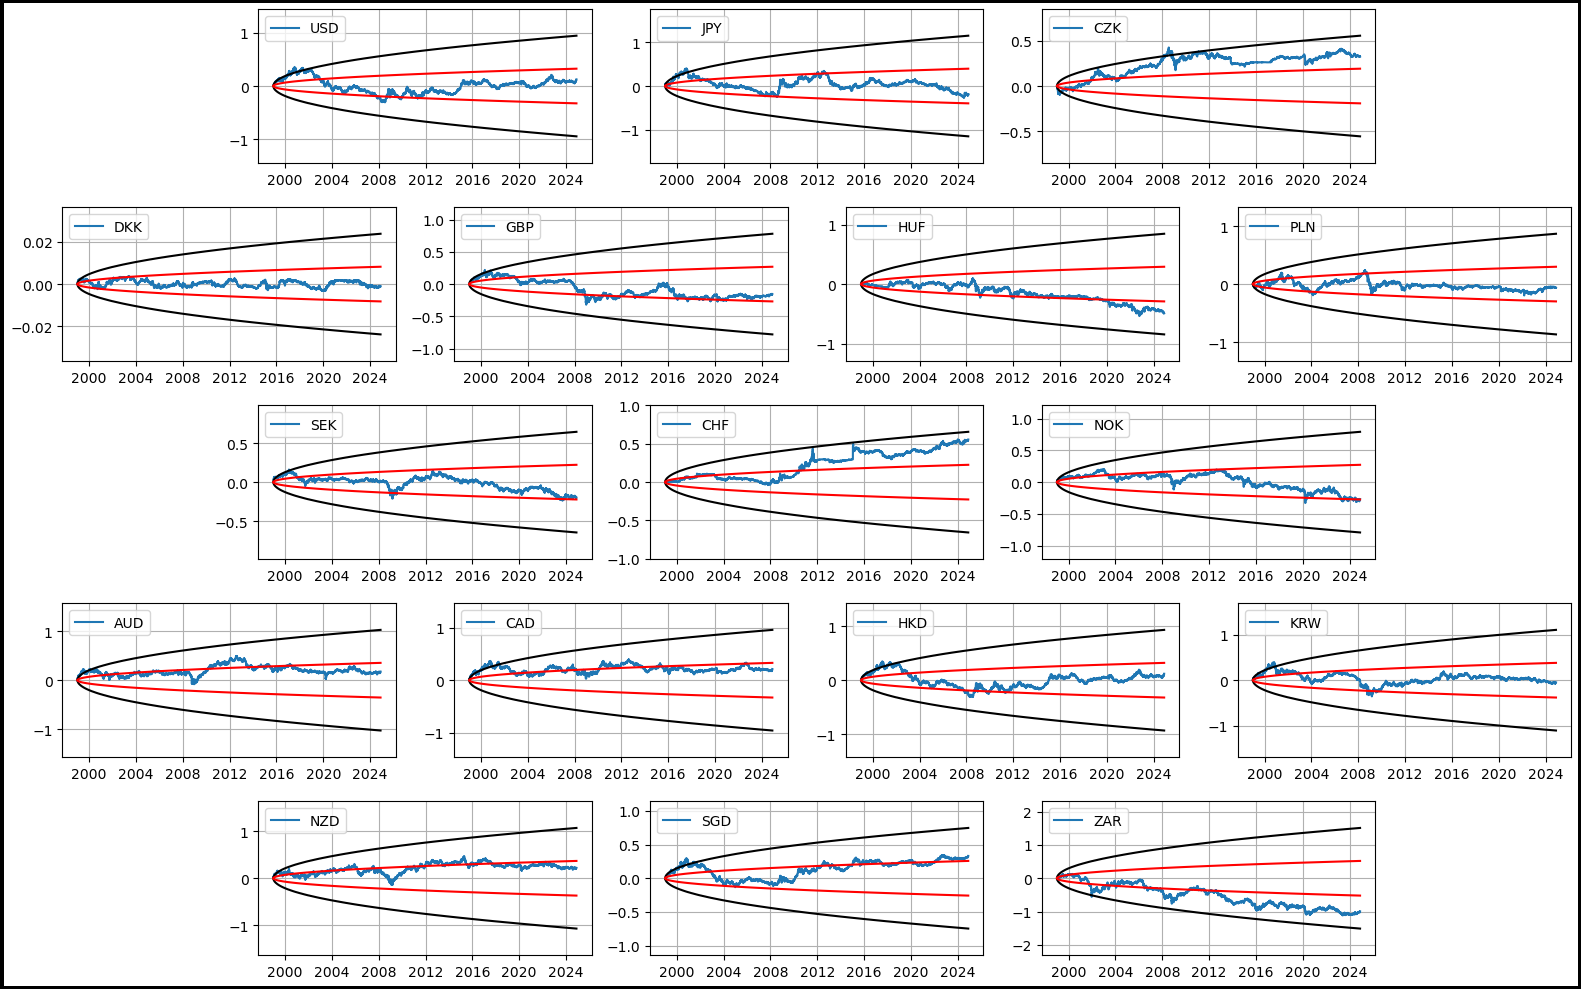

In [116]:
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(5, 8)

fig.subplots_adjust(top=0.85, bottom=0.15, left=0.2, hspace=0.8)

fig.patch.set_linewidth(5)
fig.patch.set_edgecolor('black')

for i in range(0,3):
    ax = plt.subplot(gs[0, 2 * i +1:2 * i + 3])
    plt.grid()
    plt.plot(Dates,dflog.iloc[:,i], label = df2.columns[i])
    plt.ylim(-3*sigmaQ[i]*np.sqrt(T),3*sigmaQ[i]*np.sqrt(T))
    plt.plot(Dates,quantile(sigmaQ[i],time),color='black')
    plt.plot(Dates,quantile(-sigmaQ[i],time),color='black')
    plt.plot(Dates,medium(sigmaQ[i],time),color='red')
    plt.plot(Dates,medium(-sigmaQ[i],time),color='red')
    plt.legend()
    
for i in range(3, 7):
    ax = plt.subplot(gs[1, 2 * i - 6:2 * i + 2 - 6])
    plt.grid()
    plt.plot(Dates,dflog.iloc[:,i], label = df2.columns[i])
    plt.ylim(-3*sigmaQ[i]*np.sqrt(T),3*sigmaQ[i]*np.sqrt(T))
    plt.plot(Dates,quantile(sigmaQ[i],time),color='black')
    plt.plot(Dates,quantile(-sigmaQ[i],time),color='black')
    plt.plot(Dates,medium(sigmaQ[i],time),color='red')
    plt.plot(Dates,medium(-sigmaQ[i],time),color='red')
    plt.legend()

for i in range(7, 10):
    ax = plt.subplot(gs[2, 2 * i - 13:2 * i + 2 - 13])
    plt.grid()
    plt.plot(Dates,dflog.iloc[:,i], label = df2.columns[i])
    plt.ylim(-3*sigmaQ[i]*np.sqrt(T),3*sigmaQ[i]*np.sqrt(T))
    plt.plot(Dates,quantile(sigmaQ[i],time),color='black')
    plt.plot(Dates,quantile(-sigmaQ[i],time),color='black')
    plt.plot(Dates,medium(sigmaQ[i],time),color='red')
    plt.plot(Dates,medium(-sigmaQ[i],time),color='red')
    plt.legend()     
    
for i in range(10, 14):
    ax = plt.subplot(gs[3, 2 * i - 20:2 * i + 2 - 20])
    plt.grid()
    plt.plot(Dates,dflog.iloc[:,i], label = df2.columns[i])
    plt.ylim(-3*sigmaQ[i]*np.sqrt(T),3*sigmaQ[i]*np.sqrt(T))
    plt.plot(Dates,quantile(sigmaQ[i],time),color='black')
    plt.plot(Dates,quantile(-sigmaQ[i],time),color='black')
    plt.plot(Dates,medium(sigmaQ[i],time),color='red')
    plt.plot(Dates,medium(-sigmaQ[i],time),color='red')
    plt.legend()
 

for i in range(14, 17):
    ax = plt.subplot(gs[4, 2 * i - 27:2 * i + 2 - 27])
    plt.grid()
    plt.plot(Dates,dflog.iloc[:,i], label = df2.columns[i])
    plt.ylim(-3*sigmaQ[i]*np.sqrt(T),3*sigmaQ[i]*np.sqrt(T))
    plt.plot(Dates,quantile(sigmaQ[i],time),color='black')
    plt.plot(Dates,quantile(-sigmaQ[i],time),color='black')
    plt.plot(Dates,medium(sigmaQ[i],time),color='red')
    plt.plot(Dates,medium(-sigmaQ[i],time),color='red')
    plt.legend()
    
plt.tight_layout()


In [117]:
np.exp(1)*df1['USD'].iloc[0]

3.2045824475703686

In [118]:
np.exp(-1)*df1['USD'].iloc[0]

0.4336930731970134

Many currencies tend to stay in more tight bounds than indicated by the confidence intervals.

### Optimal payoff based on smaller variance.

So we may use discrepancy of the physical measure assumption PM ~ N(sigmaQ^2.T/2, sigmaP^2.T) versus the risk neutral measure assumption PY ~ N(0, sigmaQ^2.T) for some smaller sigmaP = scaling.sigmaQ.

In [119]:
from scipy.stats import multivariate_normal

The price of the optimal portfolio is the likelihood ratio of these two densities. The following function works for any number of currencies.

In [120]:
def MY(SigmaQ,SigmaP,X,T,t):
    s1 = np.array(SigmaQ)
    s2 = np.array(SigmaP)*t/T+np.array(SigmaQ)*(1-t/T)
    if t > 0:
        PY = multivariate_normal.pdf(X,np.zeros(s1.shape[0]),s1*t)
        PM = multivariate_normal.pdf(X,np.diag(s1)*t/2,s2*t)
        return PM/PY
    else:
        return 1

The corresponding hedge (weights in the foreign currencies).

In [121]:
def weights(SigmaQ,SigmaP,X,T,t):
    s1 = np.array(SigmaQ)*t
    s2 = (np.array(SigmaP)*t/T+np.array(SigmaQ)*(1-t/T))*t
    if t > 0:
        a = np.linalg.inv(s2).dot(np.diag(s1))/2 +(np.linalg.inv(s1)-np.linalg.inv(s2)).dot(X) 
    else:
        s1 = np.array(SigmaQ)
        a = np.linalg.inv(s1).dot(np.diag(s1))/2
    return a

### Example: Currency Pairs

For instance, two currencies, USD, EUR:

In [122]:
s0 = covmatrix.loc[["USD"],["USD"]]

Choose scaling parameter.

In [123]:
scaling = 0.8

In [124]:
M2 = np.empty(len(time))

In [125]:
for i in range(len(time)):
    M2[i] = MY(s0,scaling**2*s0,[dfbrown[["USD"]].iloc[i]],T,time[i])

Price evolution in EUR. Using currencies FX rates, we get USD and Index (0.5.EUR + 0.5.USD) prices. 

In [126]:
M2USD = M2*df1["USD"]/df1["USD"].iloc[0]
M2I = M2/2 + M2*df1["USD"]/df1["USD"].iloc[0]/2

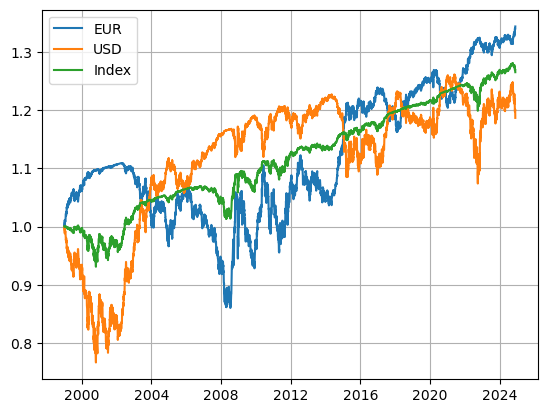

In [127]:
plt.figure()
plt.plot(Dates, M2, label="EUR")
plt.plot(Dates, M2USD, label="USD")
plt.plot(Dates, M2I, label="Index")
plt.legend()
plt.grid()
plt.show()

Various performance statistics. It does not look bad, especially when benchmarked against the index.

In [128]:
sharpe(pd.Series(M2))

0.247900788598917

In [129]:
max_drawdown(pd.Series(M2))

0.22418591741771954

In [130]:
sharpe(pd.Series(M2USD))

0.14470241218788096

In [131]:
max_drawdown(pd.Series(M2USD))

0.2333435250980671

In [132]:
sharpe(pd.Series(M2I))

0.42887801583146934

In [133]:
max_drawdown(pd.Series(M2I))

0.07091801918907259

Visualizing the hedging strategy.

In [134]:
H2 = np.empty(len(time))

In [135]:
for i in range(len(time)):
    H2[i] = weights(s0,scaling**2*s0,[dfbrown[["USD"]].iloc[i]],T,time[i])

Weights in USD and EUR (the complementary weight to 1).

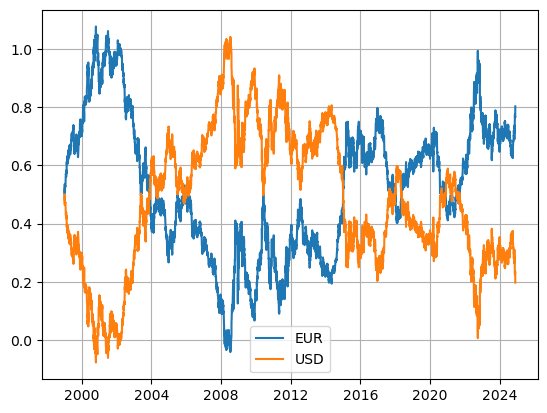

In [136]:
plt.figure()
plt.plot(Dates, 1 - H2, label="EUR")
plt.plot(Dates, H2, label="USD")
plt.legend()
plt.grid()
plt.show()

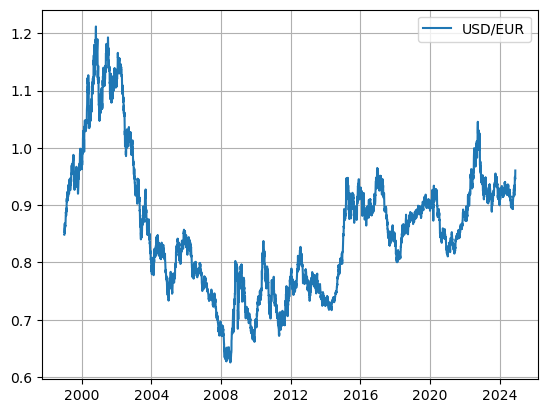

In [137]:
plt.figure()
plt.grid()
plt.plot(Dates,df2['USD'], label = "USD/EUR")
plt.legend()
plt.show()

Basically, buy low, sell high strategy, compare it with the USD/EUR exchange rate above.

Replicating portfolio.

In [138]:
P2 = np.empty(sampling_points+1)

In [139]:
P2[0] = 1

for i in range(sampling_points):
    P2[i+1] =  P2[i] + H2[i]*P2[i]*simplereturns["USD"].iloc[i+1]

Theoretical price vs realized price from hedging.

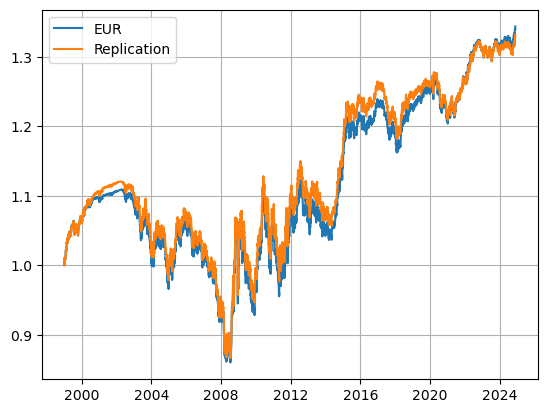

In [140]:
plt.figure()
plt.plot(Dates, M2, label="EUR")
plt.plot(Dates, P2, label="Replication")
plt.legend()
plt.grid()
plt.show()

Not bad.

### Currency triplets

For instance EUR, USD, JPY.

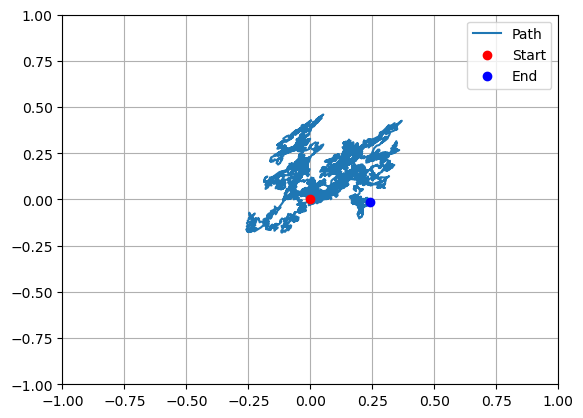

In [141]:
plt.figure()
plt.plot(dfbrown['USD'], dfbrown['JPY'], label='Path')
plt.scatter(dfbrown['USD'].iloc[0], dfbrown['JPY'].iloc[0], color='red', label='Start', zorder=5)
plt.scatter(dfbrown['USD'].iloc[-1], dfbrown['JPY'].iloc[-1], color='blue', label='End', zorder=5)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid()
plt.legend()
plt.show()


In [142]:
s1 = covmatrix.loc[["USD", "JPY"],["USD", "JPY"]]

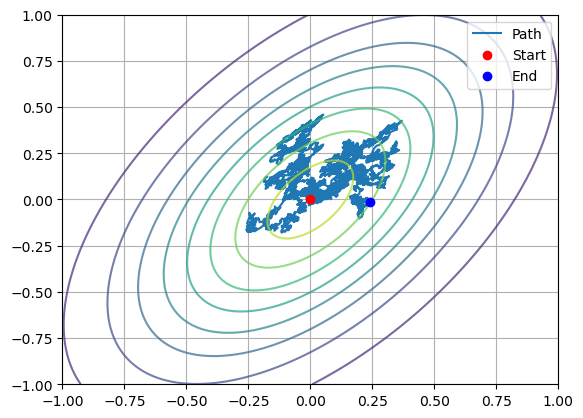

In [143]:
cov_scaled = s1 * T

# Create a grid of points over which to evaluate the density
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Create the multivariate normal distribution with zero mean and scaled covariance
rv = multivariate_normal(mean=[0, 0], cov=cov_scaled)

# Calculate the density for each point in the grid
Z = rv.pdf(pos)

# Plot the path
plt.figure()
plt.plot(dfbrown['USD'], dfbrown['JPY'], label='Path')

# Highlight the first and last points
plt.scatter(dfbrown['USD'].iloc[0], dfbrown['JPY'].iloc[0], color='red', label='Start', zorder=5)
plt.scatter(dfbrown['USD'].iloc[-1], dfbrown['JPY'].iloc[-1], color='blue', label='End', zorder=5)

# Add isolines
plt.contour(X, Y, Z, levels=10, cmap='viridis', alpha=0.7)

# Set limits, grid, and legend
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid()
plt.legend()
plt.show()


Optimal portolio.

In [144]:
M3 = np.empty(len(time))

In [145]:
for i in range(len(time)):
    M3[i] = MY(s1,scaling**2*s1,dfbrown[["USD","JPY"]].iloc[i],T,time[i])

Different benchmarks.

In [146]:
M3USD = M3*df1["USD"]/df1["USD"].iloc[0]
M3JPY = M3*df1["JPY"]/df1["JPY"].iloc[0]
M3I = M3/3 + M3*df1["USD"]/df1["USD"].iloc[0]/3 + M3*df1["JPY"]/df1["JPY"].iloc[0]/3

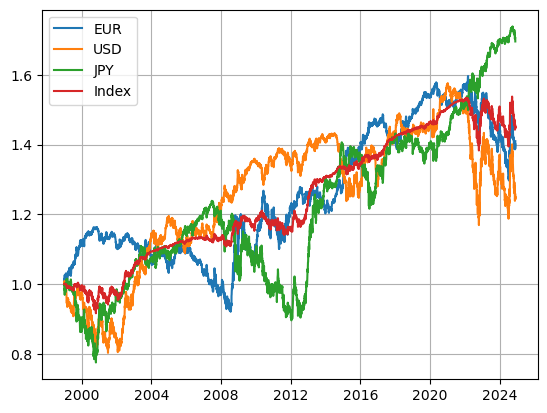

In [147]:
plt.figure()
plt.plot(Dates, M3, label="EUR")
plt.plot(Dates, M3USD, label="USD")
plt.plot(Dates, M3JPY, label="JPY")
plt.plot(Dates, M3I, label="Index")
plt.legend()
plt.grid()
plt.show()

Different performance statistics. 

In [148]:
sharpe(pd.Series(M3))

0.24379817835122147

In [149]:
max_drawdown(pd.Series(M3))

0.20819473398182087

In [150]:
sharpe(pd.Series(M3USD))

0.15238174462313528

In [151]:
max_drawdown(pd.Series(M3USD))

0.2581560393910538

In [152]:
sharpe(pd.Series(M3JPY))

0.2984353762445275

In [153]:
max_drawdown(pd.Series(M3JPY))

0.2766488459393657

In [154]:
sharpe(pd.Series(M3I))

0.43152908615968955

In [155]:
max_drawdown(pd.Series(M3I))

0.09833878471749291

Hedge.

In [156]:
H3 = pd.DataFrame(columns = ["USD", "JPY"], index = dfbrown.index)

In [157]:
for i in range(len(time)):
    H3.iloc[i] = weights(s1,scaling**2*s1,dfbrown[["USD","JPY"]].iloc[i],T,time[i])

Weights in currencies. One would currently short USD and long JPY.

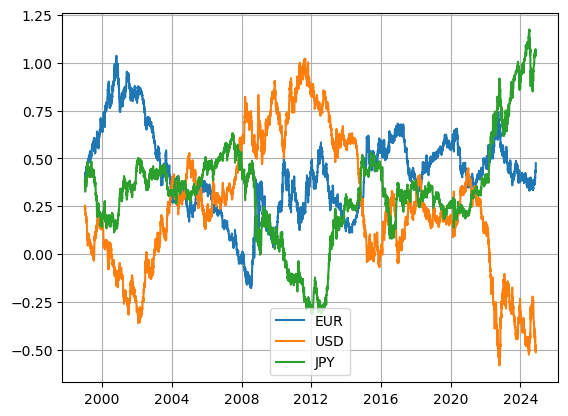

In [158]:
plt.figure()
plt.plot(Dates, 1 - pd.DataFrame.sum(H3, axis = 1), label="EUR")
plt.plot(Dates, H3.iloc[:,0], label="USD")
plt.plot(Dates, H3.iloc[:,1], label="JPY")
plt.legend()
plt.grid()
plt.show()

Replicating portfolio.

In [159]:
P3 = np.empty(sampling_points+1)

In [160]:
P3[0] = 1

for i in range(sampling_points):
    P3[i+1] =  P3[i] + H3.iloc[i,:].dot(simplereturns[["USD","JPY"]].iloc[i+1])*P3[i]

Resulting fit.

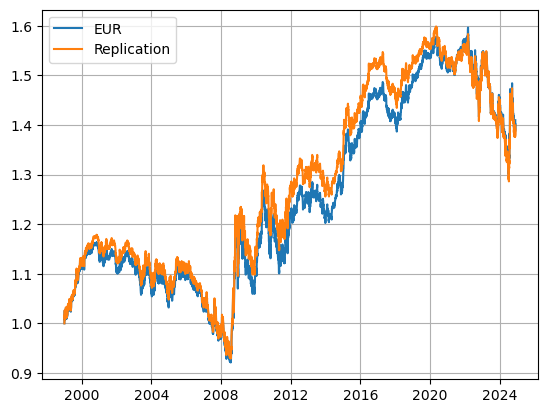

In [161]:
plt.figure()
plt.plot(Dates, M3, label="EUR")
plt.plot(Dates, P3, label="Replication")
plt.legend()
plt.grid()
plt.show()

The fit is OK, but it is not completely perfect. The basic assumption for replication is constancy of the parameters, now we have the complete correlation structure.